In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

In [2]:
dataset = pd.read_csv('../input/digit-recognizer/train.csv')
print(dataset.shape)
# Pixel0 ~ Pixel783までの計784カラム, sqrt(784) = 28 * 28 の画像データ
label_counts = dataset['label'].value_counts()
print(f'Label counts:\n {label_counts}')

(42000, 785)
Label counts:
 1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64


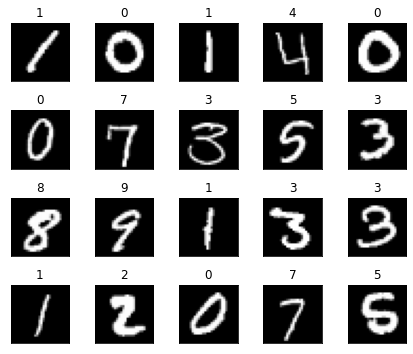

In [5]:
fig, ax = plt.subplots(4,5)
fig.set_figheight(5)
num_read_img = 20

for image_index in range(0,num_read_img):
    pixels = dataset.iloc[image_index,1:].values.reshape(28,28)
    draw_axis= ax[int(image_index/5),int(image_index%5)]
    draw_axis.imshow(pixels, cmap='gray')
    draw_axis.set_title(dataset.iloc[image_index,0])
    draw_axis.axes.xaxis.set_visible(False)
    draw_axis.axes.yaxis.set_visible(False)
plt.tight_layout()
plt.show()

In [3]:
label = dataset.loc[:,'label']
#label = pd.get_dummies(label, drop_first=False)
images = dataset.iloc[:,1:].values

# https://keras.io/ja/layers/convolutional/
# 入力: 'data_format='channels_first'の場合， (batch_size, channels, rows, cols)の4階テンソル'
#       'data_format='channels_last'の場合， (batch_size, rows, cols, channels)の4階テンソルになります．
# Conv2D層への入力のため、4次元にreshpae。 batsh_sizeはtrain_test_splitで変わるのですべてを意味する"-1"
images = images.reshape(-1,28,28,1)/255

# labelは名義尺度のため、そのままでは数値尺度として扱われてしまう？
# ということでOnehot-encoding
label = pd.get_dummies(label, columns=['label'], drop_first=False)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images,label, test_size=0.2)
print(X_train.shape)

(33600, 28, 28, 1)


In [8]:
# CNNの初期化。単純なSequentialモデルで作成。
cnn = tf.keras.models.Sequential()

# 畳み込み https://keras.io/ja/layers/convolutional/
# 128x128 RGB画像ではinput_shape=(128, 128, 3)となります．
# 最初のレイヤーだけは、入り口となる入力シェイプが必要
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[28, 28, 1], data_format='channels_last'))

# tf.keras.layers.BatchNormalization https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization
# Batch Normalization：ニューラルネットワークの学習を加速させる汎用的で強力な手法 - DeepAge https://deepage.net/deep_learning/2016/10/26/batch_normalization.html
cnn.add(tf.keras.layers.BatchNormalization())
# Poolingにより、ダウンサンプリング
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
# 画像サイズはPoolingにより14*14に
cnn.add(tf.keras.layers.Dropout(0.4))

# 2層目の中間層を追加
cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
# 画像サイズはPoolingにより7*7に
cnn.add(tf.keras.layers.Dropout(0.4))

# 3層目の中間層を追加
#cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
#cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='same'))
# 画像サイズは'padding=same'のため、Poolingにより4*4に
#cnn.add(tf.keras.layers.Dropout(0.25))

# Flattening
cnn.add(tf.keras.layers.Flatten())

# 接続
# unitsは   レイヤーの出力形状
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
cnn.add(tf.keras.layers.Dropout(0.4))

# 出力層
#cnn.add(tf.keras.layers.Dense(units=10, activation='sigmoid'))
cnn.add(tf.keras.layers.Dense(10, activation='softmax'))

# Compiling the CNN
# 評価関数の選定 -> https://keras.io/ja/metrics/
# The difference between sparse_categorical_crossentropy and categorical_crossentropy is whether your targets are one-hot encoded.
cnn.compile(optimizer = 'adam', loss = tf.keras.losses.categorical_crossentropy, metrics = ['accuracy'])

In [9]:
answer = cnn.fit(images, label, epochs = 50, batch_size = 20)

Epoch 1/50
1680/1680 [==============================] - 5s 3ms/step - loss: 0.4361 - accuracy: 0.8671
Epoch 2/50
1680/1680 [==============================] - 5s 3ms/step - loss: 0.1843 - accuracy: 0.9457
Epoch 3/50
1680/1680 [==============================] - 5s 3ms/step - loss: 0.1497 - accuracy: 0.9557
Epoch 4/50
1680/1680 [==============================] - 5s 3ms/step - loss: 0.1266 - accuracy: 0.9652
Epoch 5/50
1680/1680 [==============================] - 5s 3ms/step - loss: 0.1137 - accuracy: 0.9676
Epoch 6/50
1680/1680 [==============================] - 5s 3ms/step - loss: 0.1051 - accuracy: 0.9698
Epoch 7/50
1680/1680 [==============================] - 5s 3ms/step - loss: 0.0957 - accuracy: 0.9720
Epoch 8/50
1680/1680 [==============================] - 5s 3ms/step - loss: 0.0858 - accuracy: 0.9745
Epoch 9/50
1680/1680 [==============================] - 5s 3ms/step - loss: 0.0883 - accuracy: 0.9753
Epoch 10/50
1680/1680 [==============================] - 5s 3ms/step - loss: 0.074

In [ ]:
score = cnn.evaluate(X_test, y_test)

In [10]:
test_dataset = pd.read_csv('../input/digit-recognizer/test.csv')
y_pred = cnn.predict(test_dataset.iloc[:,:].values.reshape(-1,28,28,1)/255)

In [11]:
imageId = np.arange(1,28001)
y_pred_selected = np.argmax(y_pred,axis=1)
print(y_pred_selected)
result_table = pd.DataFrame({ 'ImageId': imageId,
                            'Label': y_pred_selected })
result_table.to_csv('prediction.csv', index=False)

[2 0 9 ... 3 9 2]
